## Part 1: Feature Engineering
- This script is used to create the features required for the model to learn

In [1]:
import datetime
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf
from pandas_datareader import data as pdr

from ta.volatility import BollingerBands

### 1. Setting the start and end date to request stock data from yfinance

In [2]:
days_sub = datetime.timedelta(1)
start_date = '2016-01-01'
# end_date = datetime.date.today() - days_sub
end_date = '2022-04-29'

### 2. Request stock data from yfinance and filtering adjusted close column

In [3]:
tick = 'AAPL'

yf.pdr_override()

df_raw = pdr.get_data_yahoo(tick, start = start_date, end = end_date)

[*********************100%***********************]  1 of 1 completed


In [4]:
df_raw.reset_index().iloc[22]

Date         2016-02-03 00:00:00
Open                       23.75
High                   24.209999
Low                        23.52
Close                    24.0875
Adj Close              22.151426
Volume                 183857200
Name: 22, dtype: object

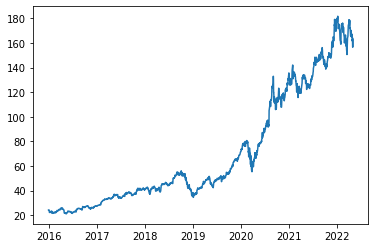

In [5]:
plt.plot(df_raw['Adj Close'])

In [6]:
df = df_raw.filter(['Adj Close'])
df

,Adj Close
Date,
2015-12-31,24.199890
2016-01-04,24.220573
2016-01-05,23.613630
2016-01-06,23.151518
2016-01-07,22.174419
...,...
2022-04-22,161.789993
2022-04-25,162.880005
2022-04-26,156.800003


### 3. Create features for the model
- Create 1 to 3 days lag prices data 
- Calculate Bollinger Band Data
- Combining all data created with Adj Close as label

In [7]:
# form df with prev close of 3 days
def create_prev_close_df(df, col_name:str):
    count = 3
    while count > 0:
        df[f"D_m{count}"] = df[col_name].shift(count)
        count -= 1
    #rearrange df with more days shift at the start -  here need to make it more dynamic
    df = df[[f"D_m{3}", f"D_m{2}", f"D_m{1}",col_name]]
    
    return df


In [8]:
df_main = create_prev_close_df(df, "Adj Close")
df_main

,D_m3,D_m2,D_m1,Adj Close
Date,,,,
2015-12-31,NaN,NaN,NaN,24.199890
2016-01-04,NaN,NaN,24.199890,24.220573
2016-01-05,NaN,24.199890,24.220573,23.613630
2016-01-06,24.199890,24.220573,23.613630,23.151518
2016-01-07,24.220573,23.613630,23.151518,22.174419
...,...,...,...,...
2022-04-22,167.399994,167.229996,166.419998,161.789993
2022-04-25,167.229996,166.419998,161.789993,162.880005
2022-04-26,166.419998,161.789993,162.880005,156.800003


In [9]:
#Calc Bollinger Band(Volatility)
## Shift bband data down by 1 as we are using previous day
bb_data = BollingerBands(df['Adj Close']).bollinger_wband()
df_bb = pd.DataFrame(bb_data).shift(1)
df_bb

,bbiwband
Date,
2015-12-31,NaN
2016-01-04,NaN
2016-01-05,NaN
2016-01-06,NaN
2016-01-07,NaN
...,...
2022-04-22,10.409541
2022-04-25,11.489273
2022-04-26,12.062967


In [10]:
df_train = df_main.merge(df_bb, how = "left", left_index =  True, right_index=True)
df_train = df_train.dropna()
df_train = df_train.rename(columns = {'bbiwband':'bb_m1'})
df_train = df_train.reset_index()


In [11]:
#Check if there are null values
df_train.isnull().sum()

Date         0
D_m3         0
D_m2         0
D_m1         0
Adj Close    0
bb_m1        0
dtype: int64

In [12]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1573 entries, 0 to 1572
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1573 non-null   datetime64[ns]
 1   D_m3       1573 non-null   float64       
 2   D_m2       1573 non-null   float64       
 3   D_m1       1573 non-null   float64       
 4   Adj Close  1573 non-null   float64       
 5   bb_m1      1573 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 73.9 KB


### 4.Treatment of features
- transformation using pct_change
- data splitting through slicing

In [13]:
# To create col of previous close price for comparison
df_train['prev_close'] = df_train['D_m1']
df_train

,Date,D_m3,D_m2,D_m1,Adj Close,bb_m1,prev_close
0,2016-02-01,21.477802,21.631834,22.379026,22.169821,12.676465,22.379026
1,2016-02-02,21.631834,22.379026,22.169821,21.721500,11.340194,22.169821
2,2016-02-03,22.379026,22.169821,21.721500,22.151426,9.810393,21.721500
3,2016-02-04,22.169821,21.721500,22.151426,22.329412,8.745457,22.151426
4,2016-02-05,21.721500,22.151426,22.329412,21.733034,8.215348,22.329412
...,...,...,...,...,...,...,...
1568,2022-04-22,167.399994,167.229996,166.419998,161.789993,10.409541,166.419998
1569,2022-04-25,167.229996,166.419998,161.789993,162.880005,11.489273,161.789993
1570,2022-04-26,166.419998,161.789993,162.880005,156.800003,12.062967,162.880005
1571,2022-04-27,161.789993,162.880005,156.800003,156.570007,13.658505,156.800003


In [14]:
#pct change prices and bb
df_train[['bb_m1', 'D_m3', 'D_m2', 'D_m1','Adj Close']] = df_train[['bb_m1', 'D_m3', 'D_m2', 'D_m1', 'Adj Close']].pct_change()
df_train = df_train.dropna().reset_index(drop=True)
df_train

,Date,D_m3,D_m2,D_m1,Adj Close,bb_m1,prev_close
0,2016-02-02,0.007172,0.034541,-0.009348,-0.020222,-0.105414,22.169821
1,2016-02-03,0.034541,-0.009348,-0.020222,0.019793,-0.134901,21.721500
2,2016-02-04,-0.009348,-0.020222,0.019793,0.008035,-0.108552,22.151426
3,2016-02-05,-0.020222,0.019793,0.008035,-0.026708,-0.060615,22.329412
4,2016-02-08,0.019793,0.008035,-0.026708,0.010530,0.042268,21.733034
...,...,...,...,...,...,...,...
1567,2022-04-22,0.014115,-0.001016,-0.004844,-0.027821,0.035306,166.419998
1568,2022-04-25,-0.001016,-0.004844,-0.027821,0.006737,0.103725,161.789993
1569,2022-04-26,-0.004844,-0.027821,0.006737,-0.037328,0.049933,162.880005
1570,2022-04-27,-0.027821,0.006737,-0.037328,-0.001467,0.132267,156.800003


In [15]:
#split into dates, x , y data
dates = df_train[['Date']]
x = df_train[['bb_m1', 'D_m3', 'D_m2', 'D_m1',]]
y = df_train[['Adj Close']]
print(dates)
print(x)
print(y)

           Date
0    2016-02-02
1    2016-02-03
2    2016-02-04
3    2016-02-05
4    2016-02-08
...         ...
1567 2022-04-22
1568 2022-04-25
1569 2022-04-26
1570 2022-04-27
1571 2022-04-28

[1572 rows x 1 columns]
         bb_m1      D_m3      D_m2      D_m1
0    -0.105414  0.007172  0.034541 -0.009348
1    -0.134901  0.034541 -0.009348 -0.020222
2    -0.108552 -0.009348 -0.020222  0.019793
3    -0.060615 -0.020222  0.019793  0.008035
4     0.042268  0.019793  0.008035 -0.026708
...        ...       ...       ...       ...
1567  0.035306  0.014115 -0.001016 -0.004844
1568  0.103725 -0.001016 -0.004844 -0.027821
1569  0.049933 -0.004844 -0.027821  0.006737
1570  0.132267 -0.027821  0.006737 -0.037328
1571  0.045279  0.006737 -0.037328 -0.001467

[1572 rows x 4 columns]
      Adj Close
0     -0.020222
1      0.019793
2      0.008035
3     -0.026708
4      0.010530
...         ...
1567  -0.027821
1568   0.006737
1569  -0.037328
1570  -0.001467
1571   0.045155

[1572 rows x 1 columns]


In [16]:
#Train-val-test split
pct_lm = int(len(df_train)*0.85) 
pct_um = int(len(df_train)*0.92) 

dates_train, x_train, y_train = dates.loc[:pct_lm-1],x.loc[:pct_lm-1], y.loc[:pct_lm-1]
dates_val,x_val, y_val = dates.loc[pct_lm:pct_um-1],x.loc[pct_lm:pct_um-1], y.loc[pct_lm:pct_um-1]
dates_test,x_test, y_test = dates.loc[pct_um:],x.loc[pct_um:], y.loc[pct_um:]

In [17]:
dates_val,x_val, y_val

(           Date
 1336 2021-05-24
 1337 2021-05-25
 1338 2021-05-26
 1339 2021-05-27
 1340 2021-05-28
 ...         ...
 1441 2021-10-21
 1442 2021-10-22
 1443 2021-10-25
 1444 2021-10-26
 1445 2021-10-27
 
 [110 rows x 1 columns],
          bb_m1      D_m3      D_m2      D_m1
 1336 -0.031437 -0.001282  0.021012 -0.014767
 1337 -0.075724  0.021012 -0.014767  0.013314
 1338 -0.092687 -0.014767  0.013314 -0.001574
 1339 -0.098755  0.013314 -0.001574 -0.000394
 1340 -0.122818 -0.001574 -0.000394 -0.012377
 ...        ...       ...       ...       ...
 1441  0.106693  0.011806  0.015080  0.003361
 1442  0.076369  0.015080  0.003361  0.001474
 1443  0.039880  0.003361  0.001474 -0.005285
 1444  0.051166  0.001474 -0.005285 -0.000336
 1445  0.044589 -0.005285 -0.000336  0.004575
 
 [110 rows x 4 columns],
       Adj Close
 1336   0.013314
 1337  -0.001574
 1338  -0.000394
 1339  -0.012377
 1340  -0.005348
 ...         ...
 1441   0.001474
 1442  -0.005285
 1443  -0.000336
 1444   0.004575
 14

In [18]:
x_train

,bb_m1,D_m3,D_m2,D_m1
0,-0.105414,0.007172,0.034541,-0.009348
1,-0.134901,0.034541,-0.009348,-0.020222
2,-0.108552,-0.009348,-0.020222,0.019793
3,-0.060615,-0.020222,0.019793,0.008035
4,0.042268,0.019793,0.008035,-0.026708
...,...,...,...,...
1331,-0.000168,-0.024938,0.017920,0.019845
1332,-0.004373,0.017920,0.019845,-0.009259
1333,0.034329,0.019845,-0.009259,-0.011246
1334,0.017207,-0.009259,-0.011246,-0.001282


<AxesSubplot:>

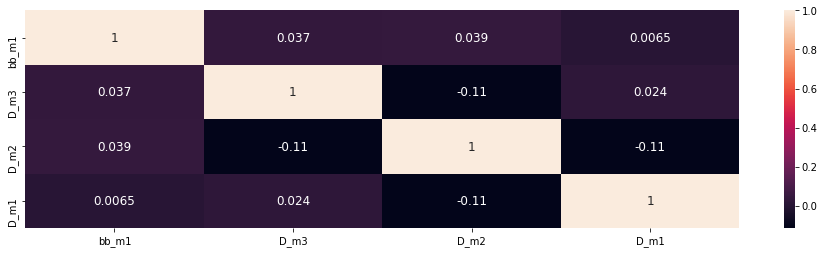

In [19]:
plt.figure(figsize=(16,4))
sns.heatmap(x_train.corr(),annot =True, annot_kws={"fontsize":12})

#Little correlation between features which shows that they are independent

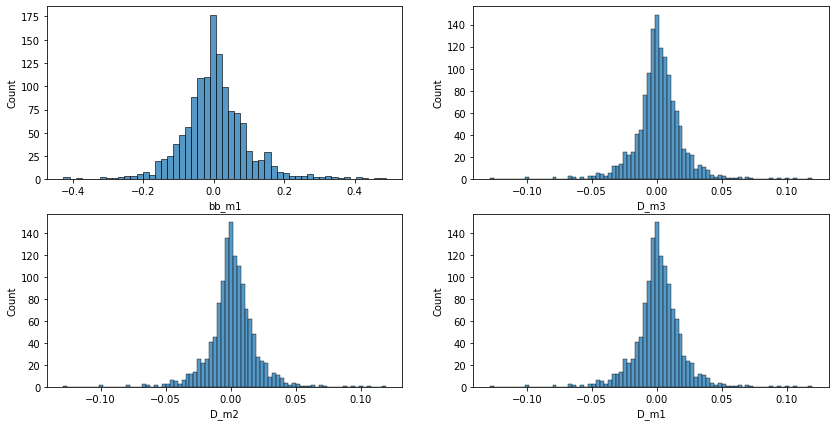

In [20]:
fig,axis = plt.subplots(2,2,figsize=(14,7))
sns.histplot(x_train.iloc[:,0],ax = axis[0,0])
sns.histplot(x_train.iloc[:,1],ax = axis[0,1])
sns.histplot(x_train.iloc[:,2],ax = axis[1,0])
sns.histplot(x_train.iloc[:,3],ax = axis[1,1])

plt.show()

#Graphical visualisation also shows that with pct_change, data is normalised for modelling

### 5. Creating validation and test set for prediction and evaluation

In [21]:
x_val = x_val.reset_index(drop=True)
x_val

,bb_m1,D_m3,D_m2,D_m1
0,-0.031437,-0.001282,0.021012,-0.014767
1,-0.075724,0.021012,-0.014767,0.013314
2,-0.092687,-0.014767,0.013314,-0.001574
3,-0.098755,0.013314,-0.001574,-0.000394
4,-0.122818,-0.001574,-0.000394,-0.012377
...,...,...,...,...
105,0.106693,0.011806,0.015080,0.003361
106,0.076369,0.015080,0.003361,0.001474
107,0.039880,0.003361,0.001474,-0.005285
108,0.051166,0.001474,-0.005285,-0.000336


In [22]:
x_test = x_test.reset_index(drop = True)
x_test

,bb_m1,D_m3,D_m2,D_m1
0,0.030131,-0.000336,0.004575,-0.003148
1,0.084937,0.004575,-0.003148,0.024992
2,0.015295,-0.003148,0.024992,-0.018156
3,-0.070720,0.024992,-0.018156,-0.005607
4,-0.034135,-0.018156,-0.005607,0.007116
...,...,...,...,...
121,0.035306,0.014115,-0.001016,-0.004844
122,0.103725,-0.001016,-0.004844,-0.027821
123,0.049933,-0.004844,-0.027821,0.006737
124,0.132267,-0.027821,0.006737,-0.037328


### 6. Create Previous close price for computing predicted price

In [23]:
df_prev = df_train[['prev_close']]

#Splitting the previous close price data to convert prediction back to price data for comparison
prev_train, prev_val, prev_test = df_prev.loc[:pct_lm-1],df_prev.loc[pct_lm:pct_um-1], df_prev.loc[pct_um:]
prev_train, prev_val, prev_test

(      prev_close
 0      22.169821
 1      21.721500
 2      22.151426
 3      22.329412
 4      21.733034
 ...          ...
 1331  126.912178
 1332  125.737152
 1333  124.323158
 1334  124.163826
 1335  126.772766
 
 [1336 rows x 1 columns],
       prev_close
 1336  124.900703
 1337  126.563652
 1338  126.364502
 1339  126.314705
 1340  124.751335
 ...          ...
 1441  148.852829
 1442  149.072235
 1443  148.284393
 1444  148.234528
 1445  148.912674
 
 [110 rows x 1 columns],
       prev_close
 1446  148.443954
 1447  152.153809
 1448  149.391357
 1449  148.553650
 1450  149.610764
 ...          ...
 1567  166.419998
 1568  161.789993
 1569  162.880005
 1570  156.800003
 1571  156.570007
 
 [126 rows x 1 columns])